## Supervised Machine Learning (Individual Task)
- Use supervised machine learning to create a model that classifies the patients based on their response to chemotherapy.
- Which features have been selected by the classifier as most important for predicting response? Are these the same genes that are differentially expressed? 
- Assess the performance of your model. Visualize, describe and discuss the results. 
- Bonus task: Train a second model using another machine learning method and compare their advantages.

### Data prep and DESeq

In [ ]:
library(tidyverse)
library(readr)
library(skimr)
library(janitor)
library(tidymodels)
library(DESeq2)
library(ranger)
library(vip)
library(patchwork)
library(forcats)

### 1. Data Preparation and Differential Expression Analysis

The first step is to load the raw gene counts and patient metadata. We will use the DESeq2 package to perform a differential gene expression (DGE) analysis. This will identify genes that are statistically different in their expression levels between patients who are "Resistant" versus "Sensitive" to chemotherapy.

We will also perform some basic data cleaning, such as converting columns to the correct data types.

In [ ]:
# daten einlesen
meta <- read_csv("data/SraRunTable.txt") %>% clean_names
counts <- read_tsv("data/salmon.merged.gene_counts.tsv")
tpm <- read_tsv("data/salmon.merged.gene_tpm.tsv")


In [ ]:
head(meta)
head(counts)
head(tpm)

In [5]:
# daten aufräumen
meta <- meta %>% 
    mutate(
        treatment_response = factor(treatment_response),
        run = as.character(run)
    ) %>%
    column_to_rownames("run")

In [6]:
# Matix erstellen
gene_id_col <- names(counts)[1]
gene_name_col <- names(counts)[2]
count_df <- counts %>%
    select(-all_of(gene_name_col)) %>%
    tibble::column_to_rownames(gene_id_col)

In [7]:
count_df[] <- lapply(count_df, as.numeric)

In [8]:
count_matrix <- as.matrix(round(count_df))
storage.mode(count_matrix) <- "integer"

In [ ]:
# check the matrix
mode(count_matrix)
head(count_matrix)


In [10]:
stopifnot(identical(colnames(count_matrix), rownames(meta)))

In [ ]:
# Erstellung des DESeq Objekts
dds <- DESeqDataSetFromMatrix(
  countData = count_matrix,
  colData   = meta,
  design    = ~ 1
)

In [12]:
colData(dds)$treatment_response <- relevel(colData(dds)$treatment_response, ref = "Sensitive")
design(dds) <- ~ treatment_response


In [263]:
dds <- DESeq(dds)

res <- results(dds, contrast = c("treatment_response","Resistant","Sensitive"))
summary(res)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 2194 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing




out of 39088 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 100, 0.26%
LFC < 0 (down)     : 97, 0.25%
outliers [1]       : 0, 0%
low counts [2]     : 16212, 41%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



After an initial run, we filter out genes with very low counts (fewer than 3 counts in at least 20% of samples) to improve the statistical power of the analysis. The final result `res_f` contains the log2 fold changes and adjusted p-values for the remaining genes.

In [ ]:
keep <- rowSums(counts(dds) >= 3) >= ceiling(0.2 * ncol(dds))
dds_f <- dds[keep, , drop = FALSE]

dds_f <- DESeq(dds_f)
res_f <- results(dds_f, contrast = c("treatment_response","Resistant","Sensitive"))
summary(res_f)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1549 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing




out of 23816 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 115, 0.48%
LFC < 0 (down)     : 98, 0.41%
outliers [1]       : 0, 0%
low counts [2]     : 2771, 12%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results




Now we will filter the results for significant hits and visualise them in a vulcanoplot. 

In [16]:
# making data frame and filtering results 
vulcano_data <- res_f %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    filter(!is.na(res_f$padj) & !is.na(res_f$log2FoldChange))

In [ ]:
# setting significance levels
padj_significance <- 0.05
log2FoldChange_significance <- 1

In [264]:
vulcano_data <- vulcano_data %>%
    mutate(
        significance = padj < padj_significance & abs(log2FoldChange) > log2FoldChange_significance,
        direction = case_when(
            log2FoldChange > log2FoldChange_significance & padj < padj_significance ~ "Up-regulated",
            log2FoldChange < -log2FoldChange_significance & padj < padj_significance ~ "Down-regulated",
            TRUE ~ "Not significant"
        )
    )

In [265]:
signif_vulcano_data <- vulcano_data %>%
    filter(significance == TRUE)


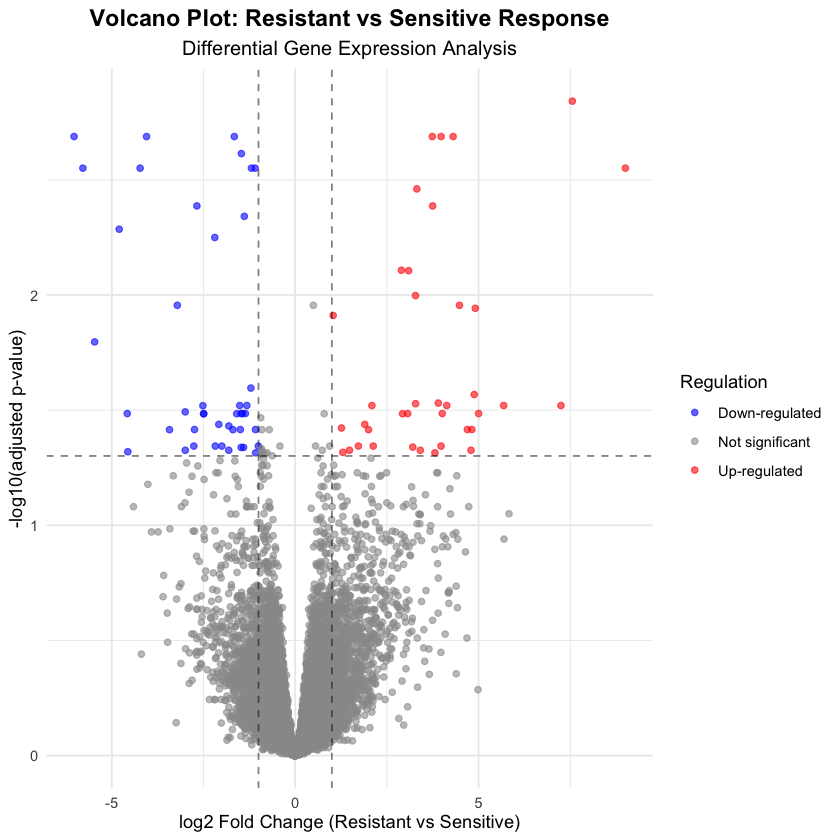

In [ ]:
# vulcano plot

vulcano_plot <- ggplot(vulcano_data, aes(x = log2FoldChange, y = -log10(padj))) +
    geom_point(aes(color = direction), alpha = 0.6) +
    scale_color_manual(values = c(
        "Up-regulated" = "red",
        "Down-regulated" = "blue",
        "Not significant" = "grey60")) +
    geom_vline(xintercept = c(log2FoldChange_significance, -log2FoldChange_significance), linetype = "dashed", alpha = 0.5, color = "black") +
    geom_hline(yintercept = -log10(padj_significance), linetype = "dashed", alpha = 0.5, color = "black") +
    labs(
      title = "Volcano Plot: Resistant vs Sensitive Response",
      subtitle = "Differential Gene Expression Analysis",
      x = "log2 Fold Change (Resistant vs Sensitive)",
      y = "-log10(adjusted p-value)",
      color = "Regulation"
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
      plot.subtitle = element_text(hjust = 0.5, size = 12)
    )

print(vulcano_plot)

### 2. Machine Learning Model Preparation

To prepare the data for machine learning, we first apply a Variance Stabilizing Transformation (VST) to the filtered count data. This step normalizes the data, making the variance more constant across the range of mean expression values, which is beneficial for many ML algorithms.

In [21]:
vst_data <- vst(dds_f, blind = FALSE)
vst_mat <- assay(vst_data)

#### Feature Selection

Our dataset has a high dimensionality problem, with over 23,000 genes (features) for only 22 samples. To build a robust model and prevent overfitting, we must perform feature selection.

We first tried feature selection based on the DESeq2 outcome, which caused dramatic data leakage and ROC-AUC of 1 in every model. We then switched to an unsupervised method. Here, we select the top 110 genes with the highest variance across all samples. The assumption is that genes with higher variance are more likely to contain information that separates the sample groups. With those 110 features we end up with a feature/sample ratio of 5:1.

In [22]:
# Prefiltering by DESeq_stat 
top_220_genes_ranked_by_DESeq_stat <- res_f %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    filter(!is.na(stat)) %>%
    mutate(abs_stat = abs(stat)) %>%
    arrange(desc(abs_stat)) %>%
    slice_head(n = 220) %>%
    pull(gene_id)


In [226]:
# Prefiltering by variance
gene_variances <- matrixStats::rowVars(vst_mat)
names(gene_variances) <- rownames(vst_mat)

top_220_genes_ranked_by_var <- names(gene_variances)[order(gene_variances, decreasing = TRUE)[1:110]]

In [227]:
# prefilter_genes <- top_220_genes_ranked_by_DESeq_stat #results in massive data leakage
prefilter_genes <- top_220_genes_ranked_by_var


ml_data <- vst_mat[prefilter_genes, ] %>%
    t() %>%
    as.data.frame() %>%
    rownames_to_column("sample_id") %>%
    mutate(
        treatment_response = meta[sample_id, "treatment_response"]
    )


#### Incorporating Clinical Data

To test whether clinical information can improve predictive performance, we create a second dataset. The raw `treatment` text was parsed into structured variables using a large language model (gemini-2.5-pro). This structured data is then combined with other clinical features (`age`, `molecular_subtype`) and merged with the gene expression data.

In [228]:
sample_treatment <- meta %>%
    rownames_to_column("sample_id") %>%
    select(sample_id, treatment) %>%
    write_csv("sample_treatment_data.csv")

**Prompt to language model with `sample_treatment_data.csv` attached**:
"I have a CSV with sample_id and treatment columns containing cancer chemotherapy regimens. Please analyze the treatment patterns and create a new CSV with 
  the following columns:

  sample_id, has_anthracycline, has_taxane, has_platinum, has_trastuzumab, has_fluorouracil, cycle_count, drug_count

  For the binary variables (has_*):
  - has_anthracycline: 1 if treatment contains anthracyclines (Doxorubicin, Epirubicin), 0 otherwise
  - has_taxane: 1 if treatment contains taxanes (Docetaxel, Paclitaxel), 0 otherwise  
  - has_platinum: 1 if treatment contains platinum compounds (Carboplatin), 0 otherwise
  - has_trastuzumab: 1 if treatment contains Trastuzumab, 0 otherwise
  - has_fluorouracil: 1 if treatment contains Fluorouracil, 0 otherwise

  For the numeric variables:
  - cycle_count: Extract the total number of treatment cycles mentioned in the treatment string
  - drug_count: Count the number of distinct drugs/compounds in the treatment regimen

  Return only the CSV data, no explanation."

In [ ]:
treatment_data <- read_csv("data/treatment_parsed.csv")

# Prepare clinical dataset
clinical_data <- meta %>%
    rownames_to_column("sample_id") %>%
    select(sample_id, age, molecular_subtype, treatment_response) %>%
    left_join(treatment_data, by = "sample_id") %>%
    mutate(
      age = as.numeric(age),
      molecular_subtype = as.factor(molecular_subtype),
      treatment_response = as.factor(treatment_response)
    ) %>%
    filter(!is.na(age), !is.na(molecular_subtype))


In [230]:
# combine clinical data with gene data

ml_data_clinical <- ml_data %>%
    left_join(clinical_data %>% select(-treatment_response), by = "sample_id")

### 3. Building Models

We will now define and train three different models using the `tidymodels` framework.

1.  **Elastic Net Regression:** A linear model that performs regularization to prevent overfitting and select the most important features.
2.  **Random Forest:** A tree-based model that can capture non-linear relationships.
3.  **Random Forest with Clinical Data:** The same tree-based model but with additional clinical features.

To ensure a robust evaluation, we use 5-fold cross-validation, stratified by the `treatment_response` outcome. `Recipes` are created to handle the specific preprocessing steps for each model, and we define a `tune_grid` to find the optimal hyperparameters for each workflow. The primary metric for evaluation will be the ROC-AUC.

In [231]:
# CV folds
set.seed(123)

cv_folds_genes <- ml_data %>%
    vfold_cv(v = 5, strata = treatment_response)

cv_folds_clinical <- ml_data_clinical %>%
    vfold_cv(v = 5, strata = treatment_response)

In [232]:
# Recipes for all three models

recipe_elastic <- ml_data %>%
    recipe(treatment_response ~ .) %>%
    update_role(sample_id,new_role = "ID") %>%
    step_normalize(all_numeric_predictors()) %>%
    step_zv(all_predictors())

recipe_rf <- ml_data %>%
    recipe(treatment_response ~ .) %>%
    update_role(sample_id, new_role = "ID") %>%
    step_zv(all_predictors())

recipe_rf_clinical <- ml_data_clinical %>%
  recipe(treatment_response ~ .) %>%
  update_role(sample_id, new_role = "ID") %>%
  step_unknown(molecular_subtype, new_level = "unknown") %>%
  step_novel(molecular_subtype) %>%
  step_dummy(molecular_subtype, one_hot = FALSE) %>%
  step_zv(all_predictors())

In [233]:
# Model specs 

elastic_spec <- logistic_reg(
    penalty = tune(),
    mixture = tune()
    ) %>%
    set_engine("glmnet") %>%
    set_mode("classification")

rf_spec <- rand_forest(
    mtry = tune(),
    trees = 1000, 
    min_n = tune()
    ) %>%
    set_engine("ranger", importance = "impurity") %>%
    set_mode("classification")

In [ ]:
# Workflows

wf_elastic <- workflow() %>%
    add_recipe(recipe_elastic) %>%
    add_model(elastic_spec)

wf_rf <- workflow() %>%
    add_recipe(recipe_rf) %>%
    add_model(rf_spec)

wf_rf_clinical <- workflow() %>%
    add_recipe(recipe_rf_clinical) %>% 
    add_model(rf_spec)


In [278]:
# Grid for Elastic Net
  elastic_grid <- grid_regular(
      penalty(range = c(-5, 1)),
      mixture(range = c(0, 1)),
      levels = 10
  )

  # Grid for Random Forest models
  rf_grid <- grid_regular(
      mtry(range = c(5, 50)),          # Try 5-50 variables per split
      min_n(range = c(5, 10)),         # Minimum 2-10 observations per node
      levels = 5                       # 5x5 = 25 combinations
  )


In [279]:
  set.seed(123)
  elastic_results <- wf_elastic %>%
      tune_grid(
          resamples = cv_folds_genes,
          grid = elastic_grid,
          metrics = metric_set(roc_auc, pr_auc),
          control = control_grid(save_pred = TRUE)
      )

→ A | warning: one multinomial or binomial class has fewer than 8  observations; dangerous ground

There were issues with some computations   A: x1

There were issues with some computations   A: x15

There were issues with some computations   A: x40





In [280]:
# Train Random Forest Model 2: Top 220 genes only
set.seed(123)
rf_results <- wf_rf %>%
    tune_grid(
        resamples = cv_folds_genes,
        grid = rf_grid,
        metrics = metric_set(roc_auc, pr_auc),
        control = control_grid(save_pred = TRUE)
    )

In [281]:
# Train Random Forest Model 3: Genes + clinical data
set.seed(123)
rf_clinical_results <- wf_rf_clinical %>%
    tune_grid(
        resamples = cv_folds_clinical,
        grid = rf_grid,
        metrics = metric_set(roc_auc, pr_auc),
        control = control_grid(save_pred = TRUE)
    )

#### Tuning Results

The tables below show the single best hyperparameter combination for each model, selected based on the highest mean ROC-AUC across the 5 cross-validation folds. For example, the Elastic Net model's best performance (mean AUC = 0.933) was achieved with a penalty of 0.1 and a mixture of 0.667.

In [294]:
# Get best models for each approach
best_elastic <- select_best(elastic_results, metric = "roc_auc")
best_rf <- select_best(rf_results, metric = "roc_auc") 
best_rf_clinical <- select_best(rf_clinical_results, metric = "roc_auc")


print(best_elastic)
print(best_rf)
print(best_rf_clinical)

# A tibble: 1 × 3
  penalty mixture .config               
    <dbl>   <dbl> <chr>                 
1     0.1   0.667 Preprocessor1_Model067
# A tibble: 1 × 3
   mtry min_n .config              
  <int> <int> <chr>                
1    16     7 Preprocessor1_Model12
# A tibble: 1 × 3
   mtry min_n .config              
  <int> <int> <chr>                
1    38     6 Preprocessor1_Model09


In [ ]:
# Compare model performance
model_comparison <- bind_rows(
    show_best(elastic_results, metric = "roc_auc", n = 1) %>% mutate(model = "Elastic Net"),
    show_best(rf_results, metric = "roc_auc", n = 1) %>% mutate(model = "Random Forest"), 
    show_best(rf_clinical_results, metric = "roc_auc", n = 1) %>% mutate(model = "RF + Clinical")
) %>%
    select(model, mean, std_err, .metric) %>%
    arrange(desc(mean))

print("Cross-validated performance of the single best hyperparameter combination for each model:")
print(model_comparison)

[1] "Model Performance Comparison (Best of ROC-AUC):"
# A tibble: 3 × 4
  model          mean std_err .metric
  <chr>         <dbl>   <dbl> <chr>  
1 Elastic Net   0.933  0.0667 roc_auc
2 Random Forest 0.533  0.162  roc_auc
3 RF + Clinical 0.4    0.172  roc_auc


### 4. Final Model Training and Analysis

The performance metrics shown above (e.g., ROC-AUC of 0.933) are estimates of how well our final model is likely to perform on new, unseen data. They were generated during the hyperparameter tuning process using cross-validation, where the model was repeatedly trained and validated on different subsets of the data.

Now that we have identified the best hyperparameters, the next step is to create the single, final model. This is done by training the model one last time on the entire dataset using those optimal parameters. This final model (`final_elastic`, `final_rf`, etc.) is the one we analyze for feature importance and would use for future predictions.

Because our dataset is very small (n=22), we did not create a separate test set. Therefore, the cross-validated ROC-AUC is our best and final estimate of the model's predictive accuracy.

In [284]:
# Final model fitting with best parameters
final_elastic <- finalize_workflow(wf_elastic, best_elastic) %>%
    fit(ml_data)

final_rf <- finalize_workflow(wf_rf, best_rf) %>%
    fit(ml_data)

final_rf_clinical <- finalize_workflow(wf_rf_clinical, best_rf_clinical) %>%
    fit(ml_data_clinical)

### 5. Feature Importance Analysis

Now we will analyze the final fitted models to understand which features they learned were the most important for distinguishing between "Resistant" and "Sensitive" patient responses.

For the Elastic Net model, importance is determined by the magnitude of the learned coefficients. Larger absolute values indicate greater influence on the prediction.

For the Random Forest models, importance is measured by "impurity," which assesses how much each feature contributes to improving the purity of the nodes in the decision trees.

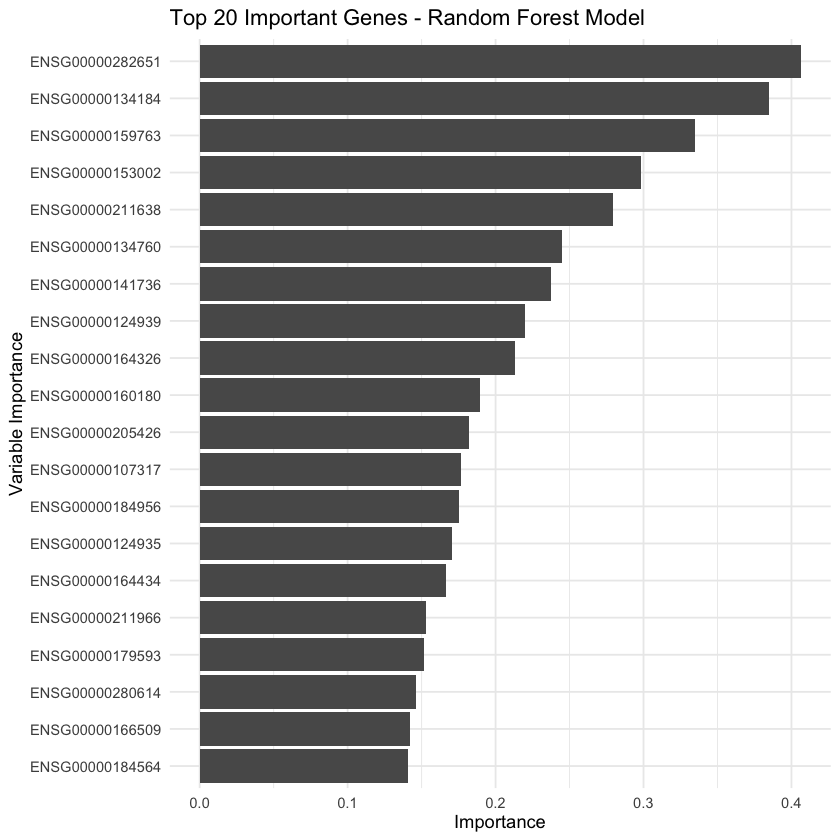

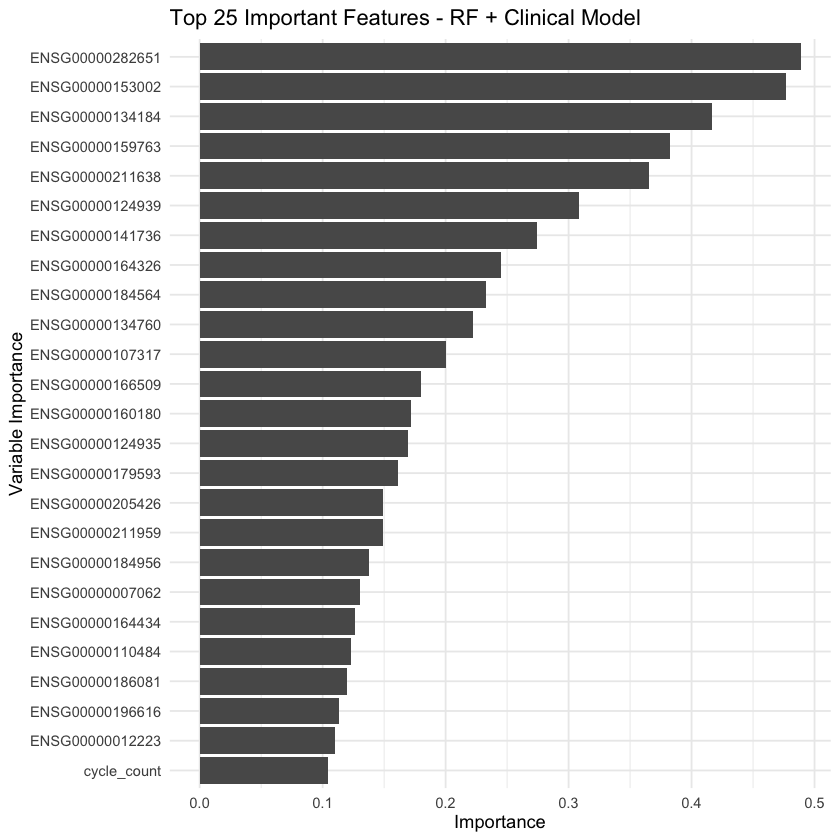

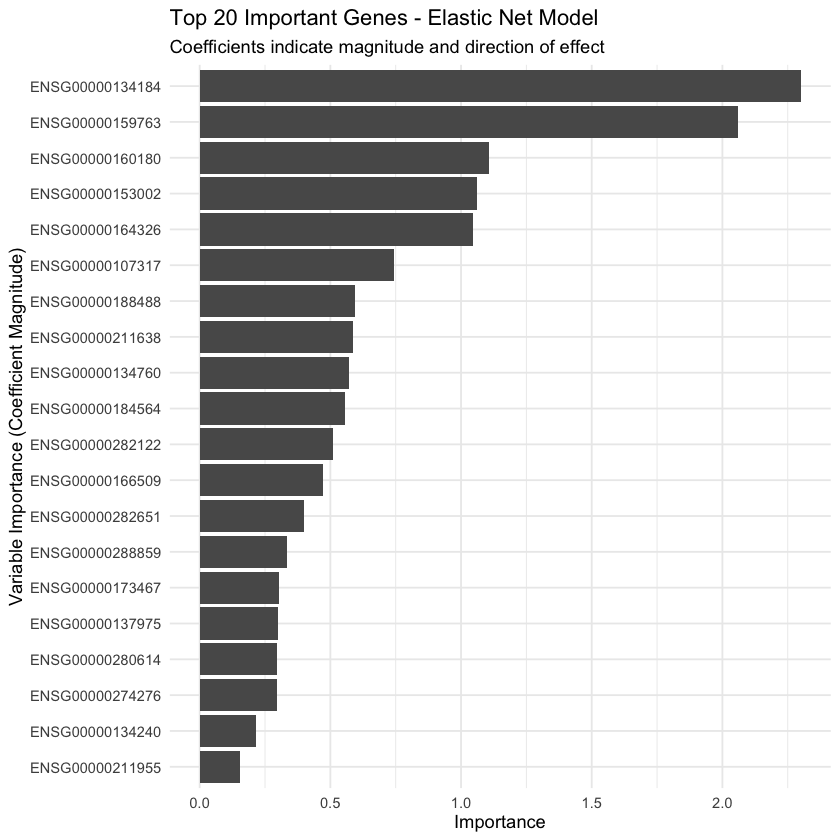

In [285]:
# Extract feature importance from Random Forest models
rf_importance <- final_rf %>%
    extract_fit_parsnip() %>%
    vip(num_features = 20, geom = "col") +
    labs(title = "Top 20 Important Genes - Random Forest Model",
         x = "Variable Importance") +
    theme_minimal()

rf_clinical_importance <- final_rf_clinical %>%
    extract_fit_parsnip() %>%
    vip(num_features = 25, geom = "col") +
    labs(title = "Top 25 Important Features - RF + Clinical Model",
         x = "Variable Importance") +
    theme_minimal()

print(rf_importance)
print(rf_clinical_importance)

# Create a feature importance plot for the Elastic Net model
elastic_importance <- final_elastic %>%
    extract_fit_parsnip() %>%
    vip(num_features = 20, geom = "col") +
    labs(
        title = "Top 20 Important Genes - Elastic Net Model",
        subtitle = "Coefficients indicate magnitude and direction of effect",
        x = "Variable Importance (Coefficient Magnitude)"
    ) +
    theme_minimal()

print(elastic_importance)

In [286]:
top_20_elastic_genes <- final_elastic %>%
    extract_fit_parsnip() %>%
    tidy() %>%
    filter(term != "(Intercept)") %>%
    arrange(desc(abs(estimate))) %>%
    slice_head(n = 20) %>%
    pull(term)

In [293]:
deseq_significant_genes <- signif_vulcano_data %>%
    pull(gene_id)

# Check overlap
overlap_genes <- intersect(top_20_elastic_genes, deseq_significant_genes)
print(paste("Overlap between top 20 Eleatic Net important genes and DESeq2 significant genes:", length(overlap_genes)))
print("Overlapping genes:")
print(overlap_genes)

[1] "Overlap between top 20 Eleatic Net important genes and DESeq2 significant genes: 5"
[1] "Overlapping genes:"
[1] "ENSG00000159763" "ENSG00000164326" "ENSG00000153002" "ENSG00000134760"
[5] "ENSG00000282651"


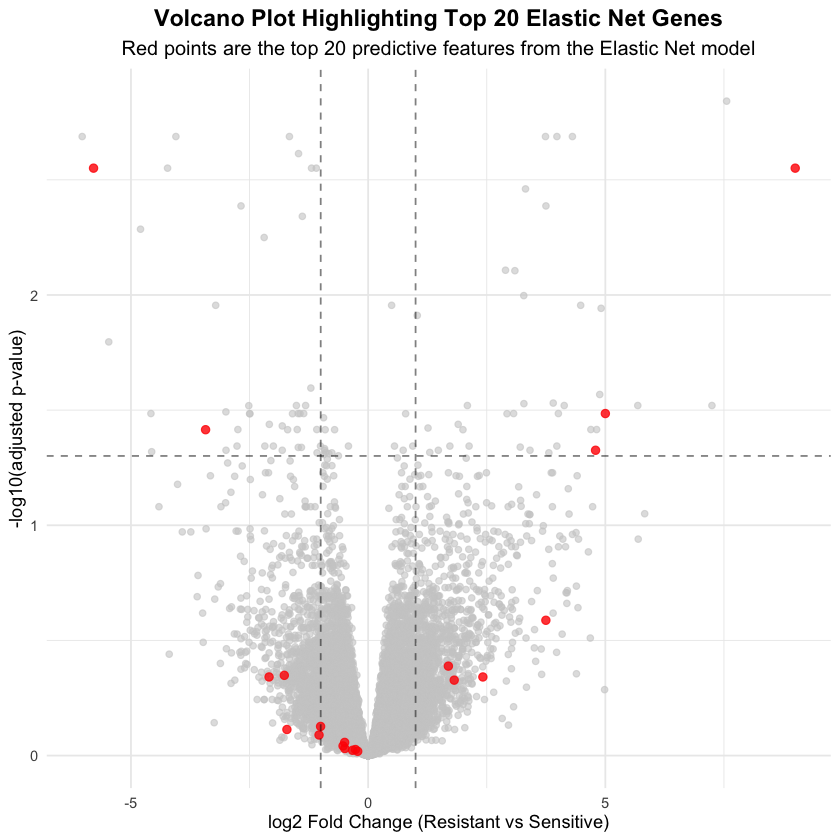

In [290]:
# Add a new column to the volcano data to identify the top ML genes
vulcano_data_highlighted <- vulcano_data %>%
    mutate(ml_highlight = ifelse(gene_id %in% top_20_elastic_genes, "Top 20 ML Gene", "Other"))

# Create the customized volcano plot
ml_vulcano_plot <- ggplot(vulcano_data_highlighted, aes(x = log2FoldChange, y = -log10(padj))) +
    # Draw all "Other" points in grey first
    geom_point(data = . %>% filter(ml_highlight == "Other"), color = "grey80", alpha = 0.6) +
    
    # Draw the "Top 20 ML Gene" points on top in red
    geom_point(data = . %>% filter(ml_highlight == "Top 20 ML Gene"), color = "red", alpha = 0.8, size = 2) +
    
    # Add significance lines
    geom_vline(xintercept = c(-1, 1), linetype = "dashed", alpha = 0.5, color = "black") +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", alpha = 0.5, color = "black") +
    
    labs(
      title = "Volcano Plot Highlighting Top 20 Elastic Net Genes",
      subtitle = "Red points are the top 20 predictive features from the Elastic Net model",
      x = "log2 Fold Change (Resistant vs Sensitive)",
      y = "-log10(adjusted p-value)"
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
      plot.subtitle = element_text(hjust = 0.5, size = 12),
      legend.position = "none" # Hide the legend as colors are self-explanatory
    )

print(ml_vulcano_plot)

The comparison shows a small overlap of only 5 genes. This indicates that the features with the highest statistical significance in differential expression are not necessarily the same ones that provide the best predictive power in a machine learning model.

### 6. Performance Visualization

This final section visualizes the performance results from our hyperparameter tuning. The boxplot compares the distribution of ROC-AUC scores across all tested hyperparameter combinations for each of the three models.

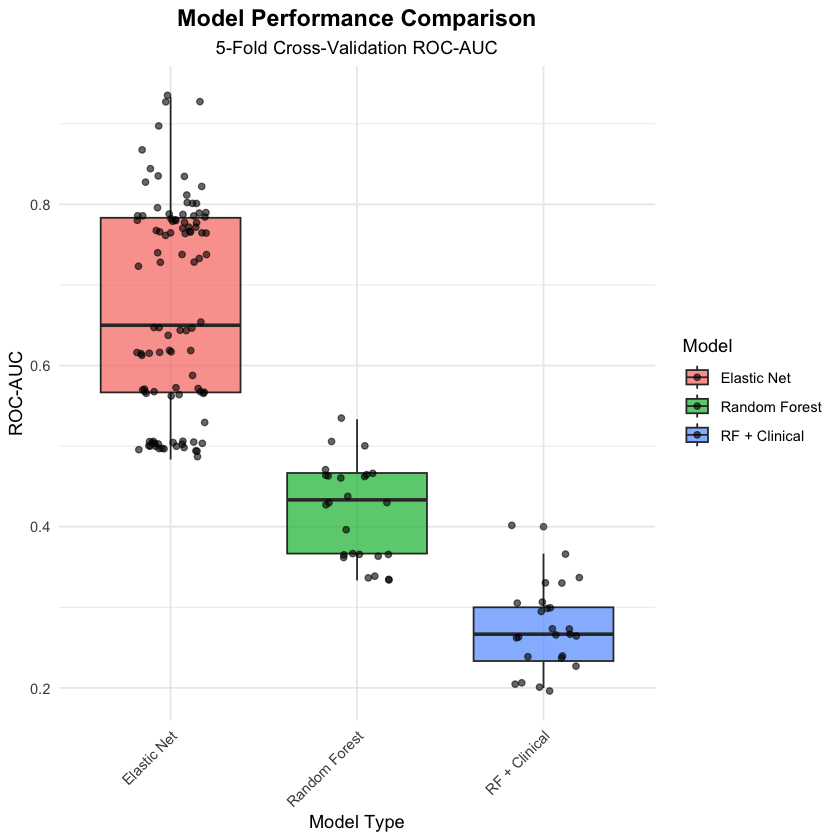

In [289]:
# Create comprehensive performance comparison plot
performance_plot <- bind_rows(
    collect_metrics(elastic_results) %>% mutate(model = "Elastic Net"),
    collect_metrics(rf_results) %>% mutate(model = "Random Forest"),
    collect_metrics(rf_clinical_results) %>% mutate(model = "RF + Clinical")
) %>%
    filter(.metric == "roc_auc") %>%
    ggplot(aes(x = model, y = mean, fill = model)) +
    geom_boxplot(alpha = 0.7) +
    geom_point(position = position_jitter(width = 0.2), alpha = 0.6) +
    labs(
        title = "Model Performance Comparison",
        subtitle = "5-Fold Cross-Validation ROC-AUC",
        x = "Model Type",
        y = "ROC-AUC",
        fill = "Model"
    ) +
    theme_minimal() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
        plot.subtitle = element_text(hjust = 0.5),
        axis.text.x = element_text(angle = 45, hjust = 1)
    )

print(performance_plot)